In [53]:
# standard libraries
import os
import sys

# third-party libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Tuple, List, Union
import joblib
import shap
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    ConfusionMatrixDisplay,
)
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import plot_tree
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import ClassificationMetric
from aif360.algorithms.postprocessing import RejectOptionClassification
from aif360.algorithms.preprocessing import Reweighing
from sklearn.preprocessing import LabelEncoder

# local module
sys.path.append(os.path.abspath(".."))
from project_config import from_root

In [54]:
PITT_CONTROL_FEATURES = from_root("data", "features", "pitt_control_features.tsv")
PITT_AD_FEATURES = from_root("data", "features", "pitt_ad_features.tsv")
PITT_SAVE_MODEL_AS = from_root("output", "models", "rf_model_pitt.pkl")
PITT_N_ESTIMATORS = 100
PITT_RANDOM_STATE = 42
PITT_TOP_K = 18
PROTECTED_ATTRIBUTES = ["gender", "age"] # for reweighing eval
# privileged -> female (0) and age >= 65 (1)
# unprivileged -> male (1) and age < 65 (0)
PROTECTED_GROUPS = {
    "gender_bin": {"privileged": 0, "unprivileged": 1},
    "age_group_65": {"privileged": 1, "unprivileged": 0},
} # for metrics eval with baseline model 

def load_pitt_data(control_path: str, ad_path: str) -> Tuple[pd.DataFrame, pd.Series]:
    df_control = pd.read_csv(control_path, sep="\t")
    df_control["label"] = 0
    df_ad = pd.read_csv(ad_path, sep="\t")
    df_ad["label"] = 1
    df_combined = pd.concat([df_control, df_ad], ignore_index=True)
    metadata_cols = ["ID", "label", "gender", "age"]
    X = df_combined.drop(columns=metadata_cols, errors="ignore")
    y = df_combined["label"]
    return X, y


def safe_metric(name: str, func) -> str:
    try:
        value = func()
        if not np.isnan(value):
            return f"{value:.3f}"
        else:
            return "N/A"
    except Exception:
        return "N/A"


def evaluate_reweighed_cv(
    control_path : str, 
    ad_path : str, 
    top_features : pd.Index, 
    protected_col : str = "gender", 
    n_splits : int = 5
) -> None: 
    df_control = pd.read_csv(control_path, sep="\t")
    df_control["label"] = 0
    df_ad = pd.read_csv(ad_path, sep="\t")
    df_ad["label"] = 1
    df = pd.concat([df_control, df_ad], ignore_index=True)

    if protected_col == "gender":
        df["protected"] = df["gender"].map({"f": 0, "m": 1}).astype(int)
    elif protected_col == "age":
        df["protected"] = (df["age"] >= 65).astype(int)
    else:
        raise ValueError("Unsupported protected_col")

    selected_cols = top_features.tolist()
    df_all = df[["label", "protected"] + selected_cols].copy()

    accs, spds, eods, aods, dis = [], [], [], [], []
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    for train_idx, test_idx in skf.split(df_all[selected_cols], df_all["label"]):
        df_train = df_all.iloc[train_idx].copy()
        df_test = df_all.iloc[test_idx].copy()

        aif_train = BinaryLabelDataset(
            df=df_train,
            label_names=["label"],
            protected_attribute_names=["protected"],
            favorable_label=1,
            unfavorable_label=0
        )

        aif_test = BinaryLabelDataset(
            df=df_test,
            label_names=["label"],
            protected_attribute_names=["protected"],
            favorable_label=1,
            unfavorable_label=0
        )

        group_key = "gender_bin" if protected_col == "gender" else "age_group_65"
        priv_val = PROTECTED_GROUPS[group_key]["privileged"]
        unpriv_val = PROTECTED_GROUPS[group_key]["unprivileged"]

        rw = Reweighing(
            privileged_groups=[{"protected": priv_val}],
            unprivileged_groups=[{"protected": unpriv_val}]
        ).fit(aif_train)

        aif_train_rw = rw.transform(aif_train)

        X_train = pd.DataFrame(aif_train_rw.features, columns=selected_cols + ["protected"]).drop(columns=["protected"])
        y_train = aif_train_rw.labels.ravel()
        sample_weights = aif_train_rw.instance_weights

        X_test = pd.DataFrame(aif_test.features, columns=selected_cols + ["protected"]).drop(columns=["protected"])
        y_test = aif_test.labels.ravel()

        model = RandomForestClassifier(n_estimators=100, random_state=42)
        model.fit(X_train, y_train, sample_weight=sample_weights)
        y_pred = model.predict(X_test)

        accs.append(accuracy_score(y_test, y_pred))

        aif_pred = aif_test.copy()
        aif_pred.labels = y_pred.reshape(-1, 1)

        metric = ClassificationMetric(
            aif_test, aif_pred,
            privileged_groups=[{"protected": priv_val}],
            unprivileged_groups=[{"protected": unpriv_val}]
        )

        spds.append(metric.statistical_parity_difference())
        eods.append(metric.equal_opportunity_difference())
        aods.append(metric.average_odds_difference())
        dis.append(metric.disparate_impact())

    print(f"\nReweighed CV Results ({protected_col}):")
    print(f"    Accuracy:                      {np.mean(accs):.3f}")
    print(f"    Statistical Parity Difference: {np.mean(spds):.3f}")
    print(f"    Equal Opportunity Difference:  {np.mean(eods):.3f}")
    print(f"    Average Odds Difference:       {np.mean(aods):.3f}")
    print(f"    Disparate Impact:              {np.mean(dis):.3f}")


def train_and_select_features(
    X : pd.DataFrame, 
    y : pd.Series, 
    top_k : int
) -> pd.Index:
    rf = RandomForestClassifier(n_estimators=PITT_N_ESTIMATORS, random_state=PITT_RANDOM_STATE, class_weight="balanced")
    rf.fit(X, y)
    importances = rf.feature_importances_
    indices = np.argsort(importances)[-top_k:]
    top_features = X.columns[indices]
    print(f"Top-{top_k} Features:\n{top_features.tolist()}")
    return top_features


def evaluate_pitt_cv(
    X : pd.DataFrame, 
    y : pd.Series, 
    top_features : pd.Index, 
    df_metadata : pd.DataFrame, 
    output_path : str, 
    n_splits : int = 5
) -> None:
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=PITT_RANDOM_STATE)

    all_y_true = []
    all_y_pred = []
    all_y_prob = []
    all_val_idx = []

    # NEW for the report, collect all metrics 
    accs, precisions, recalls, f1s, aucs = [], [], [], [], []


    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
        X_train, X_val = X.iloc[train_idx][top_features], X.iloc[val_idx][top_features]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        clf = RandomForestClassifier(n_estimators=PITT_N_ESTIMATORS, random_state=PITT_RANDOM_STATE, class_weight="balanced")
        clf.fit(X_train, y_train)

        y_pred = clf.predict(X_val)
        y_prob = clf.predict_proba(X_val)[:, 1]

        all_y_true.extend(y_val)
        all_y_pred.extend(y_pred)
        all_y_prob.extend(y_prob)
        all_val_idx.extend(val_idx)

        
        print(f"\nFold {fold} Accuracy: {accuracy_score(y_val, y_pred):.3f}")
        print(classification_report(y_val, y_pred, digits=3))

        # added for the report, collect metrics
        accs.append(accuracy_score(y_val, y_pred))
        report = classification_report(y_val, y_pred, output_dict=True)
        precisions.append(report["macro avg"]["precision"])
        recalls.append(report["macro avg"]["recall"])
        f1s.append(report["macro avg"]["f1-score"])
        aucs.append(roc_auc_score(y_val, y_prob))

    # save predictions & metadata
    df_preds = df_metadata.iloc[all_val_idx].copy()
    df_preds["original_index"] = all_val_idx
    df_preds["Label"] = all_y_true
    df_preds["predicted_label"] = all_y_pred
    df_preds["prob_1"] = all_y_prob

    # sort by og index
    df_preds = df_preds.sort_values("original_index").reset_index(drop=True)

    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    df_preds.to_csv(output_path, sep="\t", index=False)

    # final performance evaluation
    print("\n--- Final Evaluation (Pitt CV) ---")
    print("Accuracy:", accuracy_score(all_y_true, all_y_pred))
    print("Classification Report:\n", classification_report(all_y_true, all_y_pred, digits=3))

    fpr, tpr, _ = roc_curve(all_y_true, all_y_prob)
    roc_auc = roc_auc_score(all_y_true, all_y_prob)
    print(f"ROC-AUC: {roc_auc:.3f}")

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"Pitt ROC (AUC = {roc_auc:.2f})", color='blue')
    plt.plot([0, 1], [0, 1], linestyle="--", color='gray')
    plt.title(f"ROC Curve Pitt")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(from_root("output", "plots", "pitt_cv_roc.png"))
    plt.show()

    cm = confusion_matrix(all_y_true, all_y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Pitt CV Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig(from_root("output", "plots", "pitt_cv_confusion_matrix.png"))
    plt.show()

    # summary for the report mean w/ std
    def format_mean_std(values):
        return f"{np.mean(values):.3f} ± {np.std(values, ddof=1):.3f}"

    print("\n--- Random Forest (Pitt CV) Summary (Mean ± Std) ---")
    print(f"Accuracy     : {format_mean_std(accs)}")
    print(f"Precision    : {format_mean_std(precisions)}")
    print(f"Recall       : {format_mean_std(recalls)}")
    print(f"F1-Score     : {format_mean_std(f1s)}")
    print(f"ROC-AUC      : {format_mean_std(aucs)}")

    

def plot_feature_correlation(
    X : pd.DataFrame, 
    features : pd.Index, 
    # title : str, 
    plot_path : str
) -> None:
    corr = X[features].corr()
    mask = np.triu(np.ones_like(corr, dtype=bool), k=1)
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap="coolwarm", 
                square=True, cbar=True)
    # plt.title(title, fontsize=14)
    plt.tight_layout()
    plt.savefig(plot_path)
    plt.show()

In [55]:
def prepare_pitt_data(
    control_path : str, 
    ad_path : str, 
    top_k : int
) -> Tuple[pd.DataFrame, pd.Series, pd.Index]:
    X, y = load_pitt_data(control_path, ad_path)
    top_features = train_and_select_features(X, y, top_k=top_k)
    return X, y, top_features

def evaluate_pitt_baseline_cv(
    X : pd.DataFrame, 
    y : pd.Series,  
    top_features : pd.Index, 
    df_metadata : pd.DataFrame, 
    output_path : str, 
    name : str = "baseline", 
    n_splits=5
) -> None:
    print(f"\nBaseline Evaluation ({name})")
    evaluate_pitt_cv(X, y, top_features, df_metadata=df_metadata, output_path=output_path, n_splits=n_splits)

def evaluate_pitt_reweighing_cv(
    control_path : str, 
    ad_path : str, 
    top_features : pd.Index, 
    protected_col : str = "gender", 
    n_splits : int = 5
) -> None:
    print(f"\nReweighed CV Evaluation ({protected_col})")
    evaluate_reweighed_cv(control_path, ad_path, top_features, protected_col=protected_col, n_splits=n_splits)

def run_pitt_evaluation(
    control_path : str, 
    ad_path : str, 
    top_k : int = 18, 
    n_splits: int = 5
) -> None:
    # load metadata first
    df_control = pd.read_csv(control_path, sep="\t")
    df_ad = pd.read_csv(ad_path, sep="\t")
    df_full = pd.concat([df_control.assign(label=0), df_ad.assign(label=1)], ignore_index=True)

    X, y, top_features = prepare_pitt_data(control_path, ad_path, top_k)

    # correlation heatmap
    plot_feature_correlation(
        X, top_features,
        # title=f"Pitt Top-{top_k} Feature Correlation Heatmap",
        plot_path=from_root("output", "plots", f"pitt_top_{top_k}_heatmap.png")
    )

    # baseline model (with prediction output)
    baseline_output_path = from_root("output", "predictions", "pitt_predictions_with_metadata.tsv")
    evaluate_pitt_baseline_cv(
        X, y, top_features,
        df_metadata=df_full,
        output_path=baseline_output_path,
        name=f"Top-{top_k}",
        n_splits=n_splits
    )

    # load again for reweighing-based evaluations (another pipeline)
    for attr in PROTECTED_ATTRIBUTES:
        evaluate_pitt_reweighing_cv(
            control_path, ad_path, top_features,
            protected_col=attr,
            n_splits=n_splits
        )

Top-18 Features:
['IU_count', 'compression_ratio', 'IU_density', 'prep_ratio', 'verb_ratio', 'stopword_ratio', 'mattr', 'unique_words', 'noun_ratio', 'third_person_ratio', 'content_density', 'idea_density', 'mean_sentence_length', 'clauses_per_sentence', 'honore_statistic', 'pronoun_ratio', 'adv_ratio', 'auxiliary_ratio']


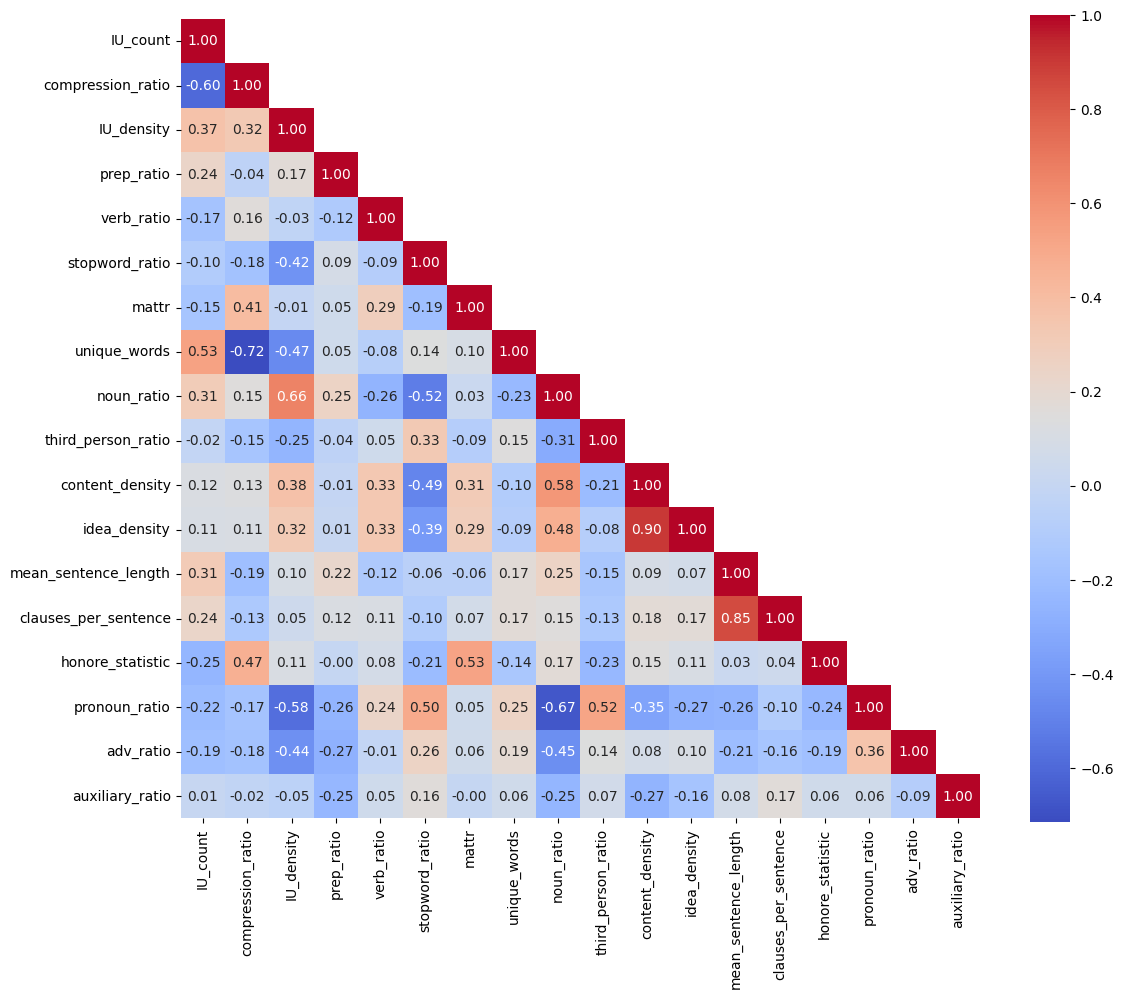


Baseline Evaluation (Top-18)

Fold 1 Accuracy: 0.691
              precision    recall  f1-score   support

           0      0.660     0.633     0.646        49
           1      0.714     0.738     0.726        61

    accuracy                          0.691       110
   macro avg      0.687     0.685     0.686       110
weighted avg      0.690     0.691     0.690       110


Fold 2 Accuracy: 0.700
              precision    recall  f1-score   support

           0      0.690     0.592     0.637        49
           1      0.706     0.787     0.744        61

    accuracy                          0.700       110
   macro avg      0.698     0.689     0.691       110
weighted avg      0.699     0.700     0.697       110


Fold 3 Accuracy: 0.727
              precision    recall  f1-score   support

           0      0.711     0.653     0.681        49
           1      0.738     0.787     0.762        61

    accuracy                          0.727       110
   macro avg      0.725   

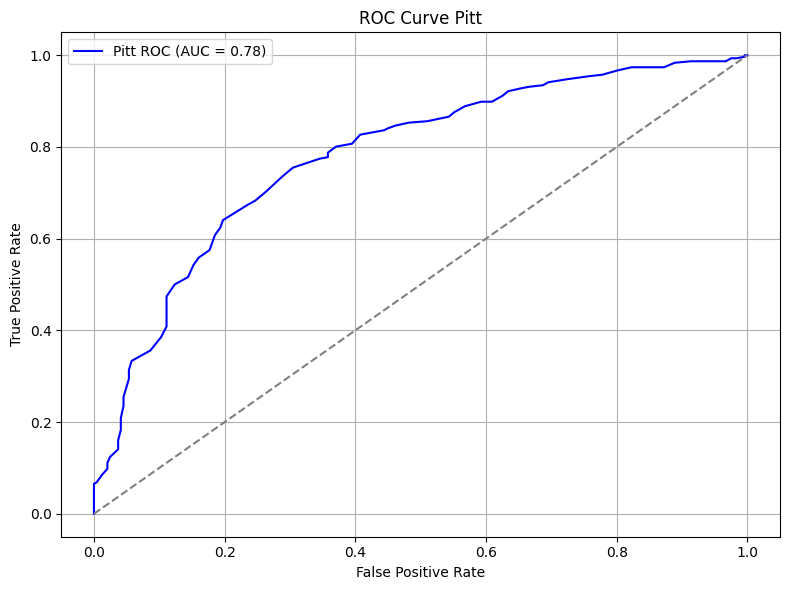

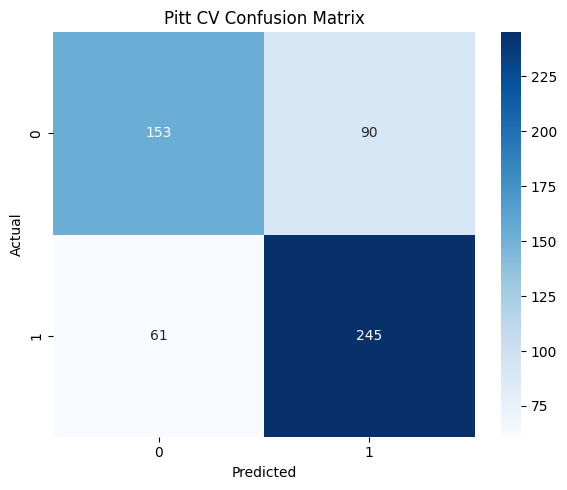


--- Random Forest (Pitt CV) Summary (Mean ± Std) ---
Accuracy     : 0.725 ± 0.029
Precision    : 0.724 ± 0.032
Recall       : 0.715 ± 0.027
F1-Score     : 0.717 ± 0.028
ROC-AUC      : 0.779 ± 0.026

Reweighed CV Evaluation (gender)

Reweighed CV Results (gender):
    Accuracy:                      0.690
    Statistical Parity Difference: 0.033
    Equal Opportunity Difference:  -0.065
    Average Odds Difference:       0.029
    Disparate Impact:              1.063

Reweighed CV Evaluation (age)

Reweighed CV Results (age):
    Accuracy:                      0.709
    Statistical Parity Difference: -0.127
    Equal Opportunity Difference:  -0.079
    Average Odds Difference:       -0.027
    Disparate Impact:              0.811


In [56]:
run_pitt_evaluation(
    control_path=PITT_CONTROL_FEATURES,
    ad_path=PITT_AD_FEATURES,
    top_k=PITT_TOP_K,
    n_splits=5
)

In [57]:
# =============================================================================
# NOTE: this cell is for reporting the dataset distribution you can skip it 
# if you are not interested in the dataset distribution
# =============================================================================


def describe_pitt_dataset(control_path, ad_path):
    df_control = pd.read_csv(control_path, sep="\t")
    df_ad = pd.read_csv(ad_path, sep="\t")

    df_control["label"] = 0
    df_ad["label"] = 1

    df_full = pd.concat([df_control, df_ad], ignore_index=True)

    print("Pitt Dataset Summary")
    print(f"Total samples: {len(df_full)}")
    print(f"Controls: {(df_full['label'] == 0).sum()}")
    print(f"AD cases: {(df_full['label'] == 1).sum()}")

    # label distribution
    print("\nLabel distribution:")
    print(df_full["label"].value_counts())

    # token/word column 
    token_col = None
    for col in df_full.columns:
        if "word" in col.lower() or "token" in col.lower():
            token_col = col
            break

    if token_col:
        print(f"\nAverage {token_col} (Control Group): {df_control[token_col].mean():.1f} ± {df_control[token_col].std():.1f}")
        print(f"Average {token_col} (AD Group): {df_ad[token_col].mean():.1f} ± {df_ad[token_col].std():.1f}")
        print(f"Average {token_col} (Both groups): {df_full[token_col].mean():.1f} ± {df_full[token_col].std():.1f}")
    else:
        print("\nNo token/word count found in feature file.")

describe_pitt_dataset(PITT_CONTROL_FEATURES, PITT_AD_FEATURES)

Pitt Dataset Summary
Total samples: 549
Controls: 243
AD cases: 306

Label distribution:
label
1    306
0    243
Name: count, dtype: int64

Average word_count (Control Group): 101.1 ± 48.6
Average word_count (AD Group): 95.8 ± 49.4
Average word_count (Both groups): 98.1 ± 49.1


In [58]:
def shap_plots() -> None:
    shap_output_dir = from_root("output", "shap", "shap_pitt")
    os.makedirs(shap_output_dir, exist_ok=True)

    X_pitt, y_pitt, top_features = prepare_pitt_data(PITT_CONTROL_FEATURES, PITT_AD_FEATURES, PITT_TOP_K)

    # retrain RF model on entire dataset using the top features
    X_pitt_topk = X_pitt[top_features]
    final_rf_model = RandomForestClassifier(
        n_estimators=PITT_N_ESTIMATORS,
        random_state=PITT_RANDOM_STATE,
        class_weight="balanced"
    )
    final_rf_model.fit(X_pitt_topk, y_pitt)
    os.makedirs(os.path.dirname(PITT_SAVE_MODEL_AS), exist_ok=True)
    joblib.dump(final_rf_model, PITT_SAVE_MODEL_AS)
 
    # SHAP explainer and values 
    explainer = shap.Explainer(final_rf_model, X_pitt_topk)
    shap_values = explainer(X_pitt_topk)

    # get SHAP values for AD (1)
    shap_values_ad = shap.Explanation(
        values=shap_values.values[:, :, 1],
        base_values=shap_values.base_values[:, 1],
        data=shap_values.data,
        feature_names=shap_values.feature_names
    )

    # SHAP bar plot
    plt.figure()
    shap.plots.bar(shap_values_ad, show=False)
    # plt.title("SHAP Bar Plot for Pitt RF Model")
    plot_path = os.path.join(shap_output_dir, "shap_barplot_pitt_rf.png")
    plt.savefig(plot_path, bbox_inches="tight")
    plt.show()

    # SHAP beeswarm plot
    plt.figure()
    shap.plots.beeswarm(shap_values_ad, show=False)
    # plt.title("SHAP Beeswarm Plot for Pitt RF Model")
    plot_path = os.path.join(shap_output_dir, "shap_beeswarm_pitt_rf.png")
    plt.savefig(plot_path, bbox_inches="tight")
    plt.show()

    # SHAP waterfall plot
    plt.figure()
    shap.plots.waterfall(shap_values_ad[0], show=False)
    # plt.title("SHAP Waterfall Plot for Pitt RF Model")
    plot_path = os.path.join(shap_output_dir, "shap_waterfall_pitt_rf.png")
    plt.savefig(plot_path, bbox_inches="tight")
    plt.show()

    # SHAP by category
    feature_categories = {
        "lexical": ["word_count", "unique_words", "type_token_ratio", "honore_statistic", "brunet_index", "mattr", "compression_ratio"],
        "semantic": ["idea_density", "IU_count", "IU_density", "named_entity_count"],
        "syntactic": ["noun_ratio", "verb_ratio", "prep_ratio", "adv_ratio", "auxiliary_ratio", "parse_tree_depth", "clauses_per_sentence", "noun_verb_ratio", "mean_sentence_length"],
        "pragmatic": ["pronoun_ratio", "first_person_ratio", "third_person_ratio", "stopword_ratio", "repetition_score"],
        "CFG": ["cfg_np_to_nn", "cfg_np_to_det_noun"],
        "disfluency": ["pause_count", "utterance_count", "disfluency_count"]
    }

    shap_df = pd.DataFrame(shap_values_ad.values, columns=top_features)

    category_shap = {}
    for category, features in feature_categories.items():
        valid_feats = [f for f in features if f in shap_df.columns]
        if valid_feats:
            category_shap[category] = shap_df[valid_feats].abs().mean(axis=1).mean()

    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(category_shap.values()), y=list(category_shap.keys()))
    # plt.title("Mean Absolute SHAP Values by Feature Category for Pitt RF Model")
    plt.xlabel("Mean |SHAP| Value")
    plt.ylabel("Feature Category")
    plt.tight_layout()
    plot_path = os.path.join(shap_output_dir, "shap_category_importance_pitt_rf.png")
    plt.savefig(plot_path, bbox_inches="tight")
    plt.show()

Top-18 Features:
['IU_count', 'compression_ratio', 'IU_density', 'prep_ratio', 'verb_ratio', 'stopword_ratio', 'mattr', 'unique_words', 'noun_ratio', 'third_person_ratio', 'content_density', 'idea_density', 'mean_sentence_length', 'clauses_per_sentence', 'honore_statistic', 'pronoun_ratio', 'adv_ratio', 'auxiliary_ratio']


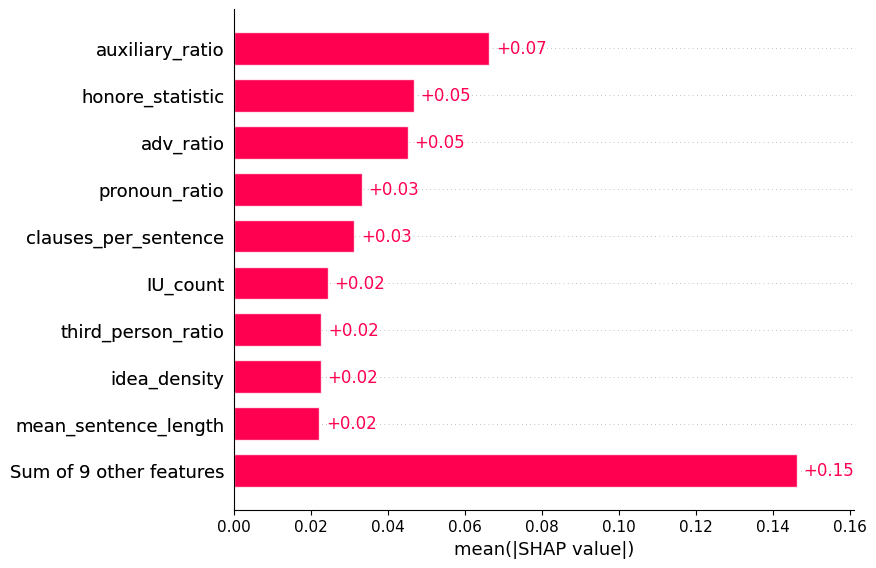

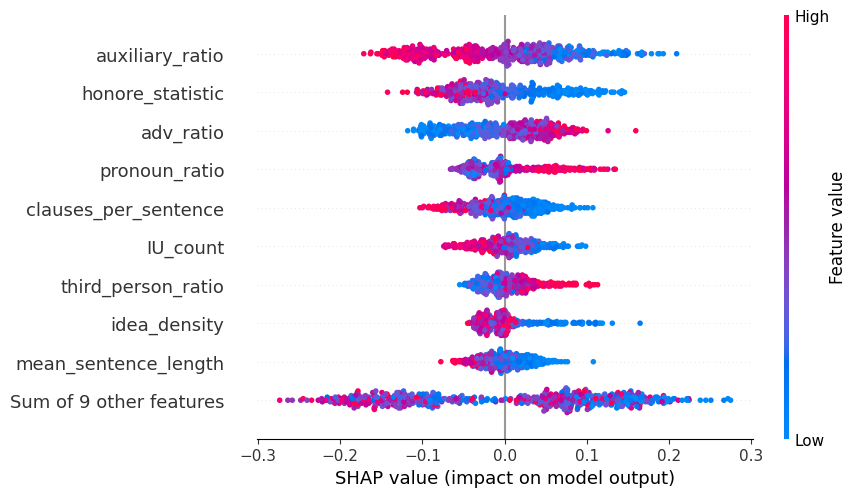

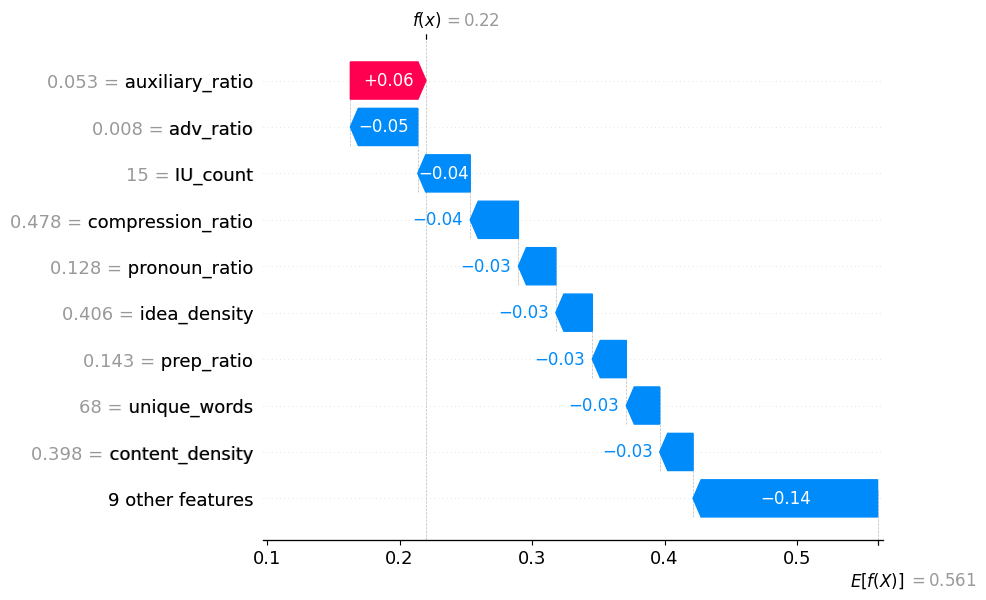

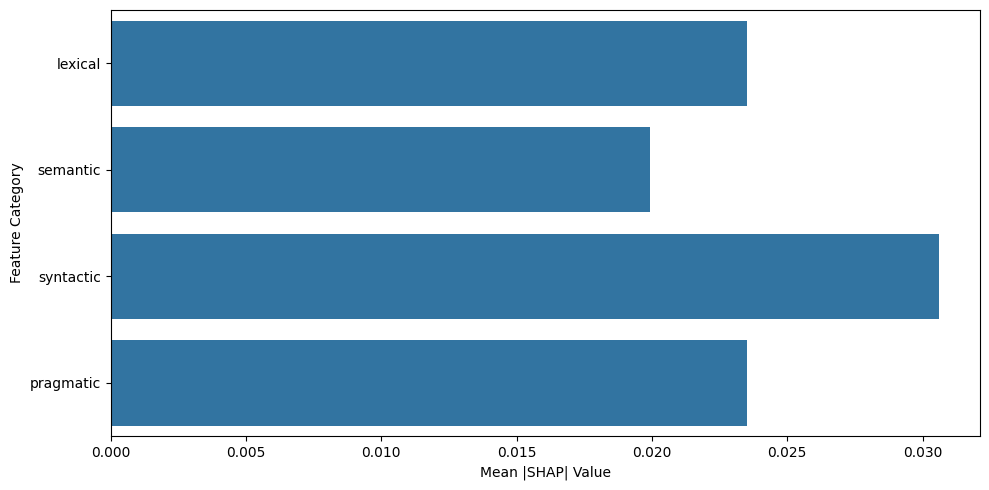

In [59]:
shap_plots()

In [60]:
def plot_rf_visualizations(
    model: RandomForestClassifier,
    X : pd.DataFrame,
    max_depth: int = 2,
    fontsize: int = 18
) -> None:
    # feature importance plot
    importances = model.feature_importances_
    feature_names = X.columns 
    # sort the features by improtance
    indices = np.argsort(importances)[::-1]
    sorted_features = feature_names[indices]
    sorted_importances = importances[indices]

    plt.figure(figsize=(10, 6))
    sns.barplot(x=sorted_importances, y=sorted_features)
    plt.title("Feature Importance - Pitt")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    plot_path = from_root("output", "plots", "rf_feature_importance_pitt.png")
    plt.savefig(plot_path)
    plt.show()

    # tree visualization
    plt.figure(figsize=(20, 10))
    plot_tree(
        model.estimators_[0], 
        feature_names=X.columns,  
        class_names=["Control", "AD"], 
        filled=True, 
        rounded=True, 
        max_depth=max_depth, 
        fontsize=fontsize
    )
    # plt.title("First Tree from Pitt RF Model")
    plt.tight_layout()
    plt.savefig(from_root("output", "plots", "rf_tree_pitt.png"))  
    plt.show()

Top-18 Features:
['IU_count', 'compression_ratio', 'IU_density', 'prep_ratio', 'verb_ratio', 'stopword_ratio', 'mattr', 'unique_words', 'noun_ratio', 'third_person_ratio', 'content_density', 'idea_density', 'mean_sentence_length', 'clauses_per_sentence', 'honore_statistic', 'pronoun_ratio', 'adv_ratio', 'auxiliary_ratio']


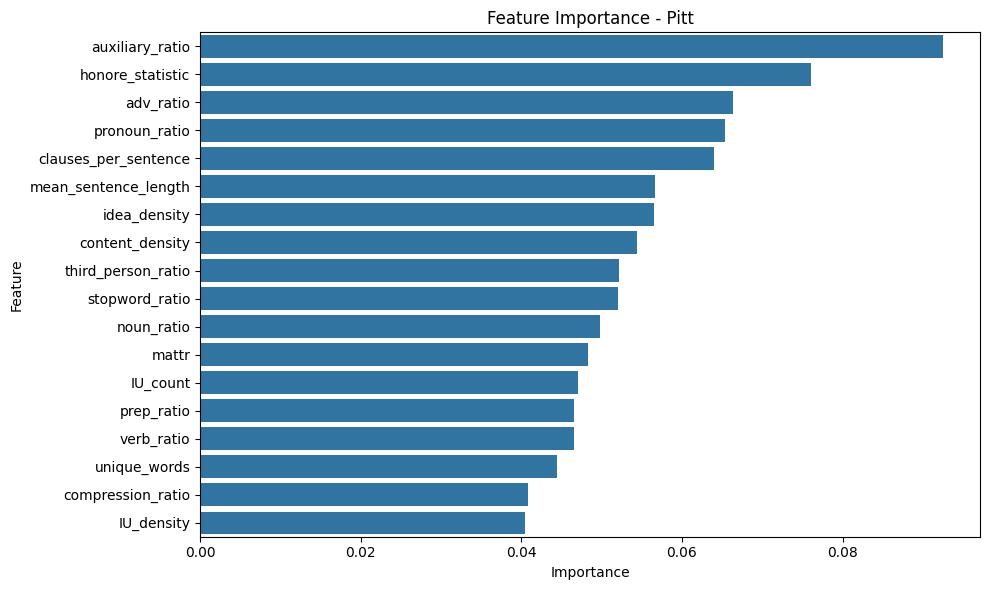

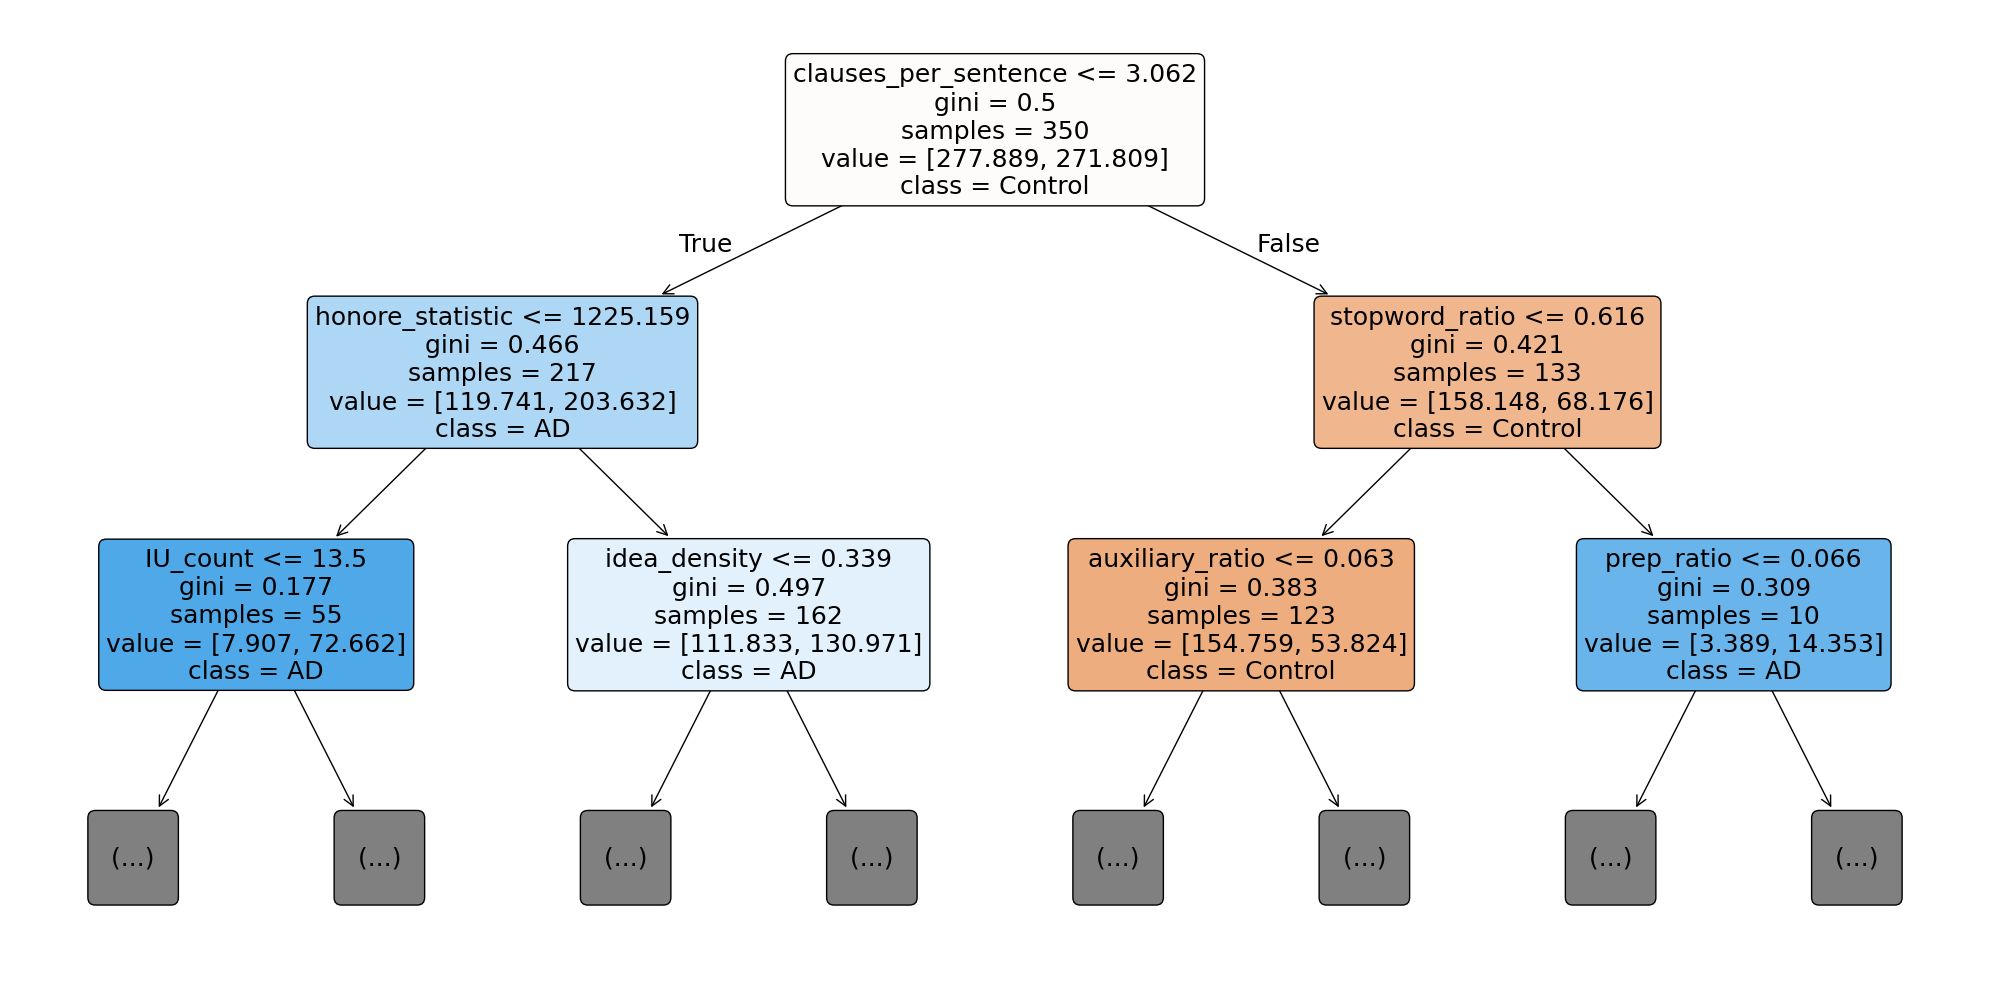

In [61]:
X_pitt, _, top_features = prepare_pitt_data(PITT_CONTROL_FEATURES, PITT_AD_FEATURES, PITT_TOP_K)
X_top = X_pitt[top_features]
rf_model = joblib.load(PITT_SAVE_MODEL_AS)

plot_rf_visualizations(rf_model, X_top)

For the report -> combine feature importance plot

In [62]:
def plot_combined_feature_importance(
    importances_adress: Union[List[float], np.ndarray],
    features_adress: Union[List[str], np.ndarray],
    importances_pitt: Union[List[float], np.ndarray],
    features_pitt: Union[List[str], np.ndarray]
) -> None:
    
    df_adress = pd.DataFrame({
        "Feature": features_adress,
        "Importance": importances_adress,
        "Dataset": "ADReSS"
    })
    
    df_pitt = pd.DataFrame({
        "Feature": features_pitt,
        "Importance": importances_pitt,
        "Dataset": "Pitt"
    })

    
    df_combined = pd.concat([df_adress, df_pitt])
    df_pivot = df_combined.pivot_table(
        index="Feature", columns="Dataset", values="Importance", fill_value=0
    )
    df_pivot = df_pivot.loc[df_pivot.max(axis=1).sort_values(ascending=False).index] # sort by max importance

    ax = df_pivot.plot(kind="barh", figsize=(10, 7), color=["#C3E6CB", "#FAD7A0"], width=0.8)
    plt.title("Feature Importance - ADReSS vs Pitt", fontsize=14)
    plt.xlabel("Importance", fontsize=12)
    plt.ylabel("Feature", fontsize=12)
    plt.legend(title="Dataset")
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    plt.gca().invert_yaxis()  # highest at top
    plt.tight_layout()

    plot_path = from_root("output", "plots", "rf_feature_importance_combined.png")
    plt.savefig(plot_path, dpi=300)
    plt.show()


Top-18 Features:
['IU_count', 'compression_ratio', 'IU_density', 'prep_ratio', 'verb_ratio', 'stopword_ratio', 'mattr', 'unique_words', 'noun_ratio', 'third_person_ratio', 'content_density', 'idea_density', 'mean_sentence_length', 'clauses_per_sentence', 'honore_statistic', 'pronoun_ratio', 'adv_ratio', 'auxiliary_ratio']


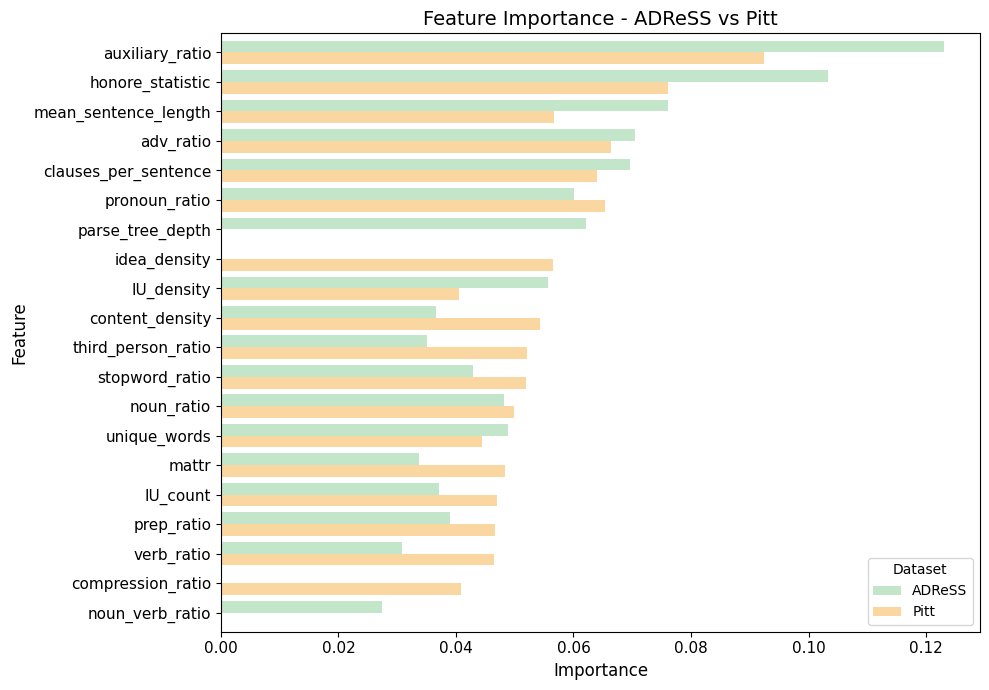

In [63]:
ADRESS_SAVE_MODEL_AS = from_root("output", "models", "rf_model_adress.pkl")
ADRESS_REDUCED_TEST_FEATURES_FILE = from_root("data", "features", "adress_test_features_reduced.tsv")

# ADReSS
adress_model = joblib.load(ADRESS_SAVE_MODEL_AS)
X_adress = pd.read_csv(ADRESS_REDUCED_TEST_FEATURES_FILE, sep="\t").drop(columns=["ID"])
importances_adress = adress_model.feature_importances_
features_adress = X_adress.columns[np.argsort(importances_adress)[::-1]]
importances_adress = np.sort(importances_adress)[::-1]

# Pitt
pitt_model = joblib.load(PITT_SAVE_MODEL_AS)
X_pitt, _, top_features = prepare_pitt_data(PITT_CONTROL_FEATURES, PITT_AD_FEATURES, PITT_TOP_K)
X_top = X_pitt[top_features]
importances_pitt = pitt_model.feature_importances_
features_pitt = X_top.columns[np.argsort(importances_pitt)[::-1]]
importances_pitt = np.sort(importances_pitt)[::-1]

plot_combined_feature_importance(importances_adress, features_adress,
                                 importances_pitt, features_pitt)

Fairness for baseline model without reweighing

In [64]:
def load_and_prepare_fairness_data() -> pd.DataFrame:
    df = pd.read_csv(from_root("output", "predictions", "pitt_predictions_with_metadata.tsv"), sep="\t")

    # protected attributes
    df["gender_bin"] = LabelEncoder().fit_transform(df["gender"].astype(str))
    df["age_group_65"] = (df["age"] >= 65).astype(int)

    df["Label"] = df["Label"].astype(int)
    df["predicted_label"] = df["predicted_label"].astype(int)

    return df


def compute_fairness_metrics(
    df: pd.DataFrame,
    protected_attr: str,
    privileged_val: int,
    unprivileged_val: int,
    label_col: str = "Label"
) -> None:
    
    aif_data = BinaryLabelDataset(
        df=df[[label_col, protected_attr]].copy(),
        label_names=[label_col],
        protected_attribute_names=[protected_attr]
    )

    aif_pred = aif_data.copy()
    aif_pred.labels = df["predicted_label"].values.reshape(-1, 1)

    metric = ClassificationMetric(
        aif_data, aif_pred,
        privileged_groups=[{protected_attr: privileged_val}],
        unprivileged_groups=[{protected_attr: unprivileged_val}]
    )

    print(f"\nFairness Metrics for {protected_attr.upper()}:")
    print(f"    Statistical Parity Difference: {safe_metric('SPD', metric.statistical_parity_difference)}")
    print(f"    Equal Opportunity Difference:  {safe_metric('EOD', metric.equal_opportunity_difference)}")
    print(f"    Average Odds Difference:       {safe_metric('AOD', metric.average_odds_difference)}")
    print(f"    Disparate Impact:              {safe_metric('DI', metric.disparate_impact)}")  

def evaluate_all_fairness_metrics_pitt() -> None:
    df = load_and_prepare_fairness_data()
    
    for attr, vals in PROTECTED_GROUPS.items():
        compute_fairness_metrics(
            df,
            protected_attr=attr,
            privileged_val=vals["privileged"],
            unprivileged_val=vals["unprivileged"]
        )    

In [65]:
evaluate_all_fairness_metrics_pitt()


Fairness Metrics for GENDER_BIN:
    Statistical Parity Difference: -0.013
    Equal Opportunity Difference:  -0.134
    Average Odds Difference:       -0.005
    Disparate Impact:              0.979

Fairness Metrics for AGE_GROUP_65:
    Statistical Parity Difference: -0.088
    Equal Opportunity Difference:  -0.005
    Average Odds Difference:       0.026
    Disparate Impact:              0.862


In [66]:
def apply_roc_and_plot(
    df: pd.DataFrame,
    group_col: str,  
    group_name: str,
    privileged_val: int,
    unprivileged_val: int,
    save_prefix: str
) -> np.ndarray:
    aif_data = BinaryLabelDataset(
        df=df[["Label", group_col]].copy(),
        label_names=["Label"],
        protected_attribute_names=[group_col],
        favorable_label=1,
        unfavorable_label=0
    )

    aif_pred = aif_data.copy()
    aif_pred.labels = df["predicted_label"].values.reshape(-1, 1)
    aif_pred.scores = df["prob_1"].values.reshape(-1, 1)

    roc = RejectOptionClassification(
        unprivileged_groups=[{group_col: unprivileged_val}],
        privileged_groups=[{group_col: privileged_val}],
        metric_name="Statistical parity difference",
        metric_ub=0.01,
        metric_lb=-0.01
    ).fit(aif_data, aif_pred)

    fair_pred = roc.predict(aif_pred)

    metric = ClassificationMetric(
        aif_data, fair_pred,
        privileged_groups=[{group_col: privileged_val}],
        unprivileged_groups=[{group_col: unprivileged_val}]
    )

    print(f"\nFairness Metrics for {group_name.upper()}:")
    print(f"    Accuracy before ROC:           {accuracy_score(df['Label'], df['predicted_label']):.3f}")
    print(f"    Accuracy after ROC:            {accuracy_score(df['Label'], fair_pred.labels.ravel()):.3f}")
    print(f"    Statistical Parity Difference: {metric.statistical_parity_difference():.3f}")
    print(f"    Equal Opportunity Difference:  {metric.equal_opportunity_difference():.3f}")
    print(f"    Average Odds Difference:       {metric.average_odds_difference():.3f}")
    print(f"    Disparate Impact:              {metric.disparate_impact():.3f}")

    # confusion matrices
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    ConfusionMatrixDisplay(confusion_matrix(df["Label"], df["predicted_label"])).plot(ax=axs[0])
    axs[0].set_title("Original Predictions")
    ConfusionMatrixDisplay(confusion_matrix(df["Label"], fair_pred.labels.ravel())).plot(ax=axs[1])
    axs[1].set_title("ROC Fair Predictions")
    plt.suptitle(f"Pitt {group_name} Mitigation")
    plt.tight_layout()
    plt.savefig(from_root("output", "fairness", f"roc_cm_{save_prefix}_pitt_rf.png"))
    plt.show()

    # ROC margin sweep -> fairness - accuracy trade-off (2nd QR)
    margins = range(1, 30, 2)
    spds, accs = [], []

    for m in margins:
        sweep = RejectOptionClassification(
            unprivileged_groups=[{group_col: unprivileged_val}],
            privileged_groups=[{group_col: privileged_val}],
            metric_name="Statistical parity difference",
            metric_ub=0.01,
            metric_lb=-0.01,
            num_ROC_margin=m
        ).fit(aif_data, aif_pred)

        pred = sweep.predict(aif_pred)
        mtr = ClassificationMetric(
            aif_data, pred,
            privileged_groups=[{group_col: privileged_val}],
            unprivileged_groups=[{group_col: unprivileged_val}]
        )

        spds.append(mtr.statistical_parity_difference())
        accs.append(accuracy_score(df["Label"], pred.labels.ravel()))

    plt.figure(figsize=(10, 5))
    plt.plot(margins, accs, label="Accuracy", marker="o")
    plt.plot(margins, spds, label="SPD", marker="x")
    plt.axhline(0.01, color="gray", linestyle="--", label="Fairness Bound")
    plt.axhline(-0.01, color="gray", linestyle="--")
    plt.xlabel("ROC Margin")
    plt.ylabel("Metric Value")
    plt.title(f"Pitt ROC Margin Sweep - {group_name}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(from_root("output", "fairness", f"roc_margin_sweep_{save_prefix}_pitt_rf.png"))
    plt.show()

    return fair_pred.labels.ravel()

def run_roc_fairness_pitt() -> pd.DataFrame:
    df = pd.read_csv(from_root("output", "predictions", "pitt_predictions_with_metadata.tsv"), sep="\t")

    df["Label"] = df["Label"].astype(int)
    df["predicted_label"] = df["predicted_label"].astype(int)

    # protected attributes
    df["gender_bin"] = LabelEncoder().fit_transform(df["gender"].astype(str))
    df["age_group_65"] = (df["age"] >= 65).astype(int)

    # ROC mitigation for gender
    df["ROC_gender_label"] = apply_roc_and_plot(
        df,
        group_col="gender_bin",
        group_name="Gender",
        privileged_val=0,
        unprivileged_val=1,
        save_prefix="gender"
    )

    # ROC mitigation for age
    df["ROC_age_label"] = apply_roc_and_plot(
        df,
        group_col="age_group_65",
        group_name="Age 65+",
        privileged_val=1,
        unprivileged_val=0,
        save_prefix="age"
    )

    return df


Fairness Metrics for GENDER:
    Accuracy before ROC:           0.725
    Accuracy after ROC:            0.729
    Statistical Parity Difference: -0.003
    Equal Opportunity Difference:  -0.129
    Average Odds Difference:       0.005
    Disparate Impact:              0.994


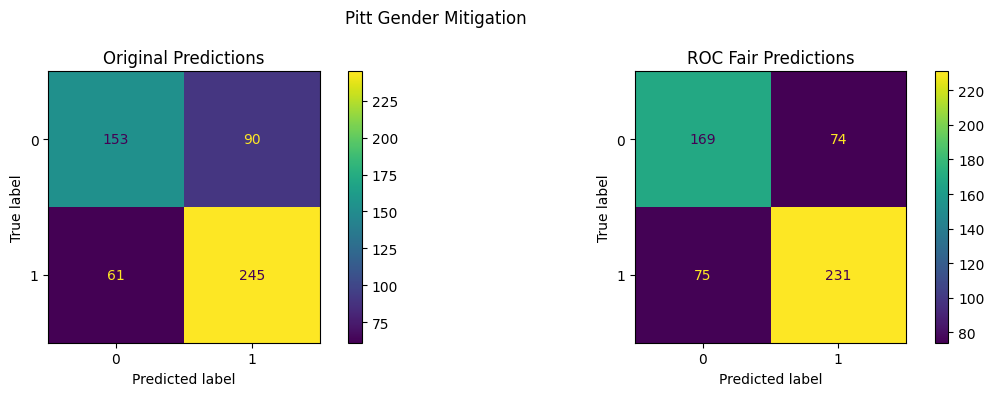

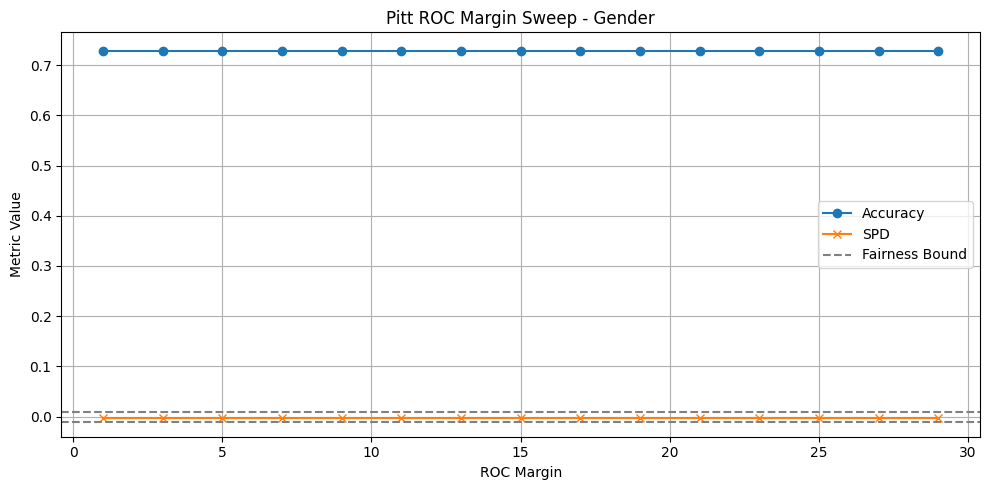


Fairness Metrics for AGE 65+:
    Accuracy before ROC:           0.725
    Accuracy after ROC:            0.712
    Statistical Parity Difference: -0.009
    Equal Opportunity Difference:  0.098
    Average Odds Difference:       0.113
    Disparate Impact:              0.980


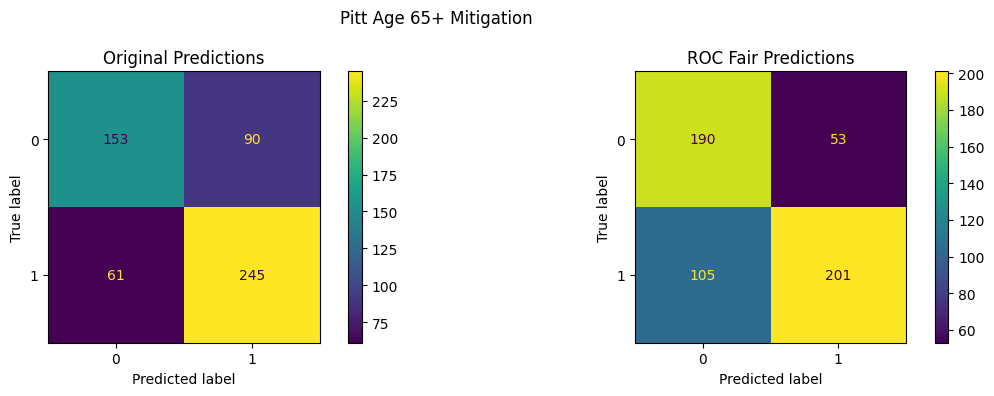

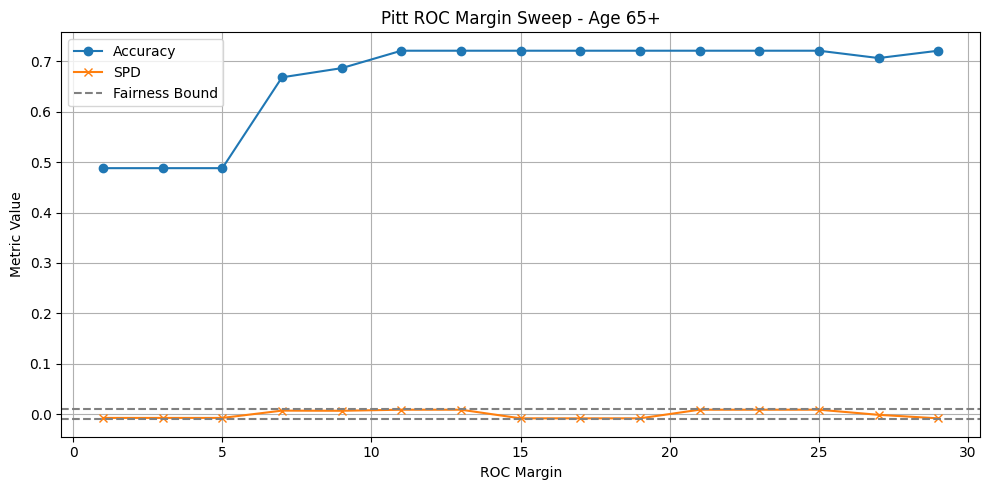

In [67]:
df_roc = run_roc_fairness_pitt()